# Sentiment Analysis Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [3]:
!unzip '/content/drive/MyDrive/tweet-sentiment-extraction.zip'

Archive:  /content/drive/MyDrive/tweet-sentiment-extraction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


## import data and visualize 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string 

from plotly import graph_objs as go
import plotly.express as px
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from palettable.colorbrewer.qualitative import Pastel1_7


%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling1D,Input,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,Model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
max_sequence = 32
vocab_size = 10000
tf.random.set_seed(42)

In [6]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
# remove null value in train data
print(train.isnull().sum())
train = train.dropna()


textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [8]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

## preprocessing data

### data cleaning
### 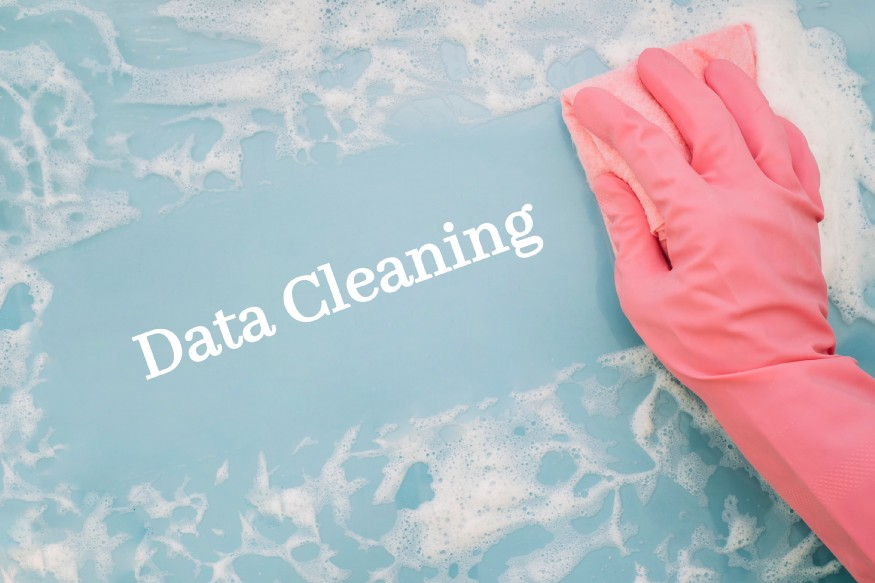

In [9]:
# function for clean data
def clean_text(text):
    '''Make text lowercase,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [10]:
# clean data
test['processed_text']= test['text'].apply(lambda x:clean_text(x))
train['processed_text']= train['text'].apply(lambda x:clean_text(x))
train['processed_selected_text']= train['selected_text'].apply(lambda x:clean_text(x))

In [11]:
train['temp_list'] = train['processed_selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title='Common words in text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### remove stop words

In [12]:
#remove stop words and convert to lower case 
stop_words = stopwords.words('english')
test['processed_text']= [' '.join([word for word in document.lower().split() if word not in stop_words]) for document in test['processed_text']]
train['processed_text']= [' '.join([word for word in document.lower().split() if word not in stop_words]) for document in train['processed_text']]
train['processed_selected_text']= [' '.join([word for word in document.lower().split() if word not in stop_words]) for document in train['processed_selected_text']]

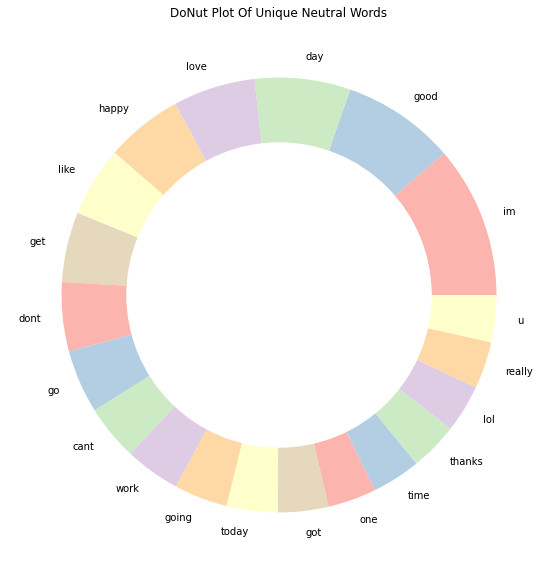

In [13]:
train['temp_list'] = train['processed_selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp['count'], labels=temp.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

### remove short words

In [14]:
# remove short words (length < 3)
train['processed_selected_text'] = train['processed_selected_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [15]:
train['temp_list'] = train['processed_selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of the most common words in text')
fig.show()

## handling train and test data 

In [16]:
# tokenisation and padding data
def tokenize(sentences,tokenizer = None):
    if tokenizer == None:
        tokenizer = Tokenizer(vocab_size,oov_token = "<OOV>")
        tokenizer.fit_on_texts(sentences)
        sequences = tokenizer.texts_to_sequences(sentences)
        padded_sens = pad_sequences(sequences,padding = "post",maxlen=max_sequence)
        return padded_sens,tokenizer
    else:
        sequences = tokenizer.texts_to_sequences(sentences)
        padded_sens = pad_sequences(sequences,padding = "post",maxlen=max_sequence)
        return padded_sens

In [17]:
# preprocess target 
def sentiment_codes(text):
  templet_dict = {'neutral':2,'positive':1,'negative':0}
  result = list((pd.Series(text)).map(templet_dict))
  return result

### manipulating training

In [18]:
# train sentiment codes
train['sent_codes'] = sentiment_codes(list(train['sentiment']))
train.head()

,textID,text,selected_text,sentiment,processed_text,processed_selected_text,temp_list,sent_codes
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id responded going,responded going,"[responded, going]",2
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,sooo sad,"[sooo, sad]",0
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,bullying,[bullying],0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,leave alone,"[leave, alone]",0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons couldnt put releases already bought,sons,[sons],0


In [19]:
# train tokenize and padding
x_train = train['processed_selected_text']
x_train,token = tokenize(list(x_train))


In [20]:
# convert train target into one hot
y_train = train['sent_codes']
y_train_hot = tf.one_hot(y_train,depth=3)
y_train_hot

<tf.Tensor: shape=(27480, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

### manipulating testing

In [21]:
# show test data and remove null value
print(test.isnull().sum())
test = test.dropna()


textID            0
text              0
sentiment         0
processed_text    0
dtype: int64


In [22]:
# test sentiment codes
test['sent_codes'] = sentiment_codes(list(test['sentiment']))
test.head()

,textID,text,sentiment,processed_text,sent_codes
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session day,2
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai also really exciting precisely skyscr...,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...,0
3,01082688c6,happy bday!,positive,happy bday,1
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,like,1


In [23]:
# test tokenize and padding
x_test = test['processed_text']
x_test = tokenize(list(x_test),token)


In [24]:
# convert test target into one hot
y_test = test['sent_codes']
y_test_hot = tf.one_hot(y_test,depth=3)
y_test_hot

<tf.Tensor: shape=(3534, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [25]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((27480, 32), (27480,), (3534, 32), (3534,))

## create TF Data Pipeline

In [26]:
def dataset_creator(x,y):
    data=tf.data.Dataset.from_tensor_slices((x,y))
    data=data.shuffle(50000)
    data=data.batch(64)
    data=data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

train_dataset = dataset_creator(x_train,y_train_hot)
test_dataset = dataset_creator(x_test,y_test_hot)

## building models

### ANN model

In [27]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [28]:
ann_model = Sequential()
ann_model.add(Input([max_sequence]))
ann_model.add(Embedding(vocab_size+1,35))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(35,activation = "relu"))
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(Dense(50,activation = "relu"))
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(Dense(25,activation = "relu"))
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(Dense(5,activation = "relu"))
ann_model.add(tf.keras.layers.Dropout(0.2))
ann_model.add(Dense(3,activation = "softmax"))



In [29]:
ann_model.compile(loss = tf.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(lr = 0.001),metrics = ['acc'])

In [30]:
# fit model and save with best accuracy 
save_model=tf.keras.callbacks.ModelCheckpoint('ann_model.h5',
                                              monitor='val_acc',
                                              mode='max',
                                              save_best_only=True) 


Epoch 1/5
687/687 [==============================] - 5s 6ms/step - loss: 1.0474 - acc: 0.4545 - val_loss: 0.7122 - val_acc: 0.7240
Epoch 2/5
687/687 [==============================] - 4s 5ms/step - loss: 0.7258 - acc: 0.7236 - val_loss: 0.6165 - val_acc: 0.7795
Epoch 3/5
687/687 [==============================] - 4s 5ms/step - loss: 0.6047 - acc: 0.7911 - val_loss: 0.6028 - val_acc: 0.7667
Epoch 4/5
687/687 [==============================] - 4s 5ms/step - loss: 0.5125 - acc: 0.8304 - val_loss: 0.5655 - val_acc: 0.8000
Epoch 5/5
687/687 [==============================] - 4s 5ms/step - loss: 0.4660 - acc: 0.8540 - val_loss: 0.5680 - val_acc: 0.8071


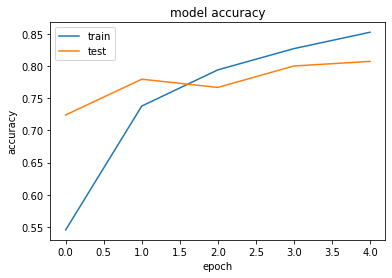

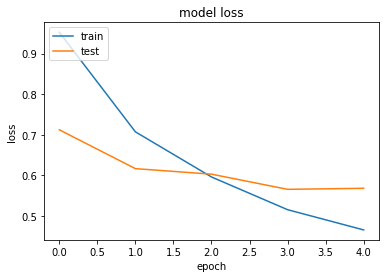

In [31]:
history = ann_model.fit(x_train,y_train,epochs=5,validation_split = 0.2,callbacks=[save_model])
plot_history(history)

### first LSTM model

In [32]:
lstm_model = Sequential([
                         Input(max_sequence),
                         Embedding(vocab_size+1,100,mask_zero=True),
                         LSTM(64),
                         Dense(units=3,activation=tf.nn.softmax),
])

In [33]:
lstm_model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['acc'])


In [34]:
# fit model and save with best accuracy
save_model=tf.keras.callbacks.ModelCheckpoint('lstm_model.h5',
                                              monitor='val_acc',
                                              mode='max',
                                              save_best_only=True) 
history= lstm_model.fit(x_train,y_train,epochs=5,validation_split = 0.2,callbacks=[save_model])

Epoch 1/5
687/687 [==============================] - 25s 33ms/step - loss: 0.7483 - acc: 0.6684 - val_loss: 0.4942 - val_acc: 0.8071
Epoch 2/5
687/687 [==============================] - 22s 32ms/step - loss: 0.3728 - acc: 0.8702 - val_loss: 0.4965 - val_acc: 0.8237
Epoch 3/5
687/687 [==============================] - 21s 31ms/step - loss: 0.2812 - acc: 0.9048 - val_loss: 0.5301 - val_acc: 0.8140
Epoch 4/5
687/687 [==============================] - 21s 31ms/step - loss: 0.2356 - acc: 0.9177 - val_loss: 0.5749 - val_acc: 0.8119
Epoch 5/5
687/687 [==============================] - 21s 31ms/step - loss: 0.2077 - acc: 0.9300 - val_loss: 0.6347 - val_acc: 0.8046


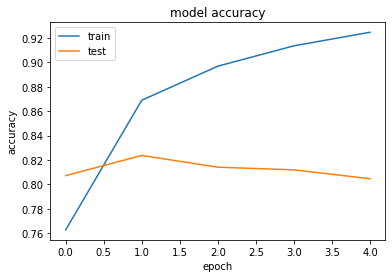

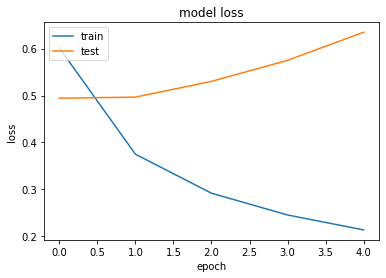

In [35]:
plot_history(history)

### second LSTM model

In [36]:
low_lstm_model = Sequential([
                         Input(max_sequence),
                         Embedding(vocab_size+1,100,mask_zero=True),
                         Bidirectional(LSTM(64)),
                         Dense(units=3,activation=tf.nn.softmax),
])

In [37]:
low_lstm_model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])


In [38]:
# fit model and save with best accuracy
save_model=tf.keras.callbacks.ModelCheckpoint('low_lstm_model.h5',
                                              monitor='val_acc',
                                              mode='max',
                                              save_best_only=True) 
history= low_lstm_model.fit(train_dataset,epochs=5,validation_data=test_dataset,callbacks=[save_model])

Epoch 1/5
430/430 [==============================] - 39s 73ms/step - loss: 0.7646 - acc: 0.6533 - val_loss: 1.1523 - val_acc: 0.5504
Epoch 2/5
430/430 [==============================] - 29s 68ms/step - loss: 0.3765 - acc: 0.8651 - val_loss: 1.3131 - val_acc: 0.5467
Epoch 3/5
430/430 [==============================] - 29s 67ms/step - loss: 0.2907 - acc: 0.8998 - val_loss: 1.1971 - val_acc: 0.5747
Epoch 4/5
430/430 [==============================] - 30s 69ms/step - loss: 0.2488 - acc: 0.9133 - val_loss: 1.5531 - val_acc: 0.5620
Epoch 5/5
430/430 [==============================] - 29s 68ms/step - loss: 0.2119 - acc: 0.9258 - val_loss: 2.1663 - val_acc: 0.5359


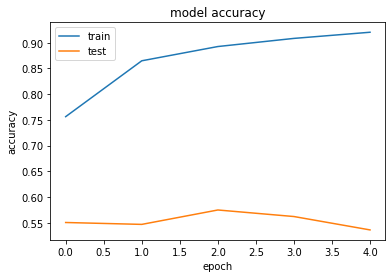

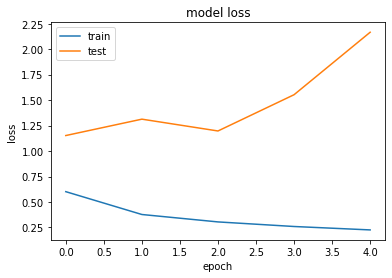

In [39]:
plot_history(history)

## evaluate models

In [40]:
templet_dict = {2:'neutral',1:'positive',0:'negative'}

In [41]:
#@title String fields

text = 'I am fine' #@param {type:"string"}

print(text)


I am fine


In [42]:
data=tokenize(list([text]),token)
result_ann_model = ann_model.predict(data)
result_lstm_model = lstm_model.predict(data)
result_low_lstm_model = low_lstm_model.predict(data)


In [43]:

print('The Sentence is: ', text)
print('result of ANN model: ',templet_dict[result_ann_model.argmax()], result_ann_model[0][result_ann_model.argmax()])
print('result of first LSTM model: ',templet_dict[result_lstm_model.argmax()], result_lstm_model[0][result_lstm_model.argmax()])
print('result of second LSTM model: ',templet_dict[result_low_lstm_model.argmax()], result_low_lstm_model[0][result_low_lstm_model.argmax()])

The Sentence is:  I am fine
result of ANN model:  neutral 0.81383455
result of first LSTM model:  neutral 0.9089395
result of second LSTM model:  neutral 0.6889536
